# VAE - MLP

In [1]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import numpy as np
from tqdm import tqdm

gpu_ctx = mx.gpu(0)
cpu_ctx = mx.cpu(0)

/home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


# Parameters

In [17]:
FILTERS = 64
LATENT_DIM = 2
HIDDEN_DIM = 400
INTPUT_DIM = 28 * 28
OUTPUT_DIM = 28 * 28
BATCH_SIZE = 100
IMG_CHNS = 1

# Define functions

In [18]:
def vae_loss(x, x_gen, z_mean, log_z_var):
    x = nd.flatten(x)
    x_gen = nd.flatten(x_gen)
    #print('x shape = {}'.format(x.shape))
    #print('x_gen sahpe = {}'.format(x_gen.shape))
    # D_KL(q(z|X) || p(z))
    kl_loss = -0.5 * nd.sum(1 + log_z_var - nd.square(z_mean) - nd.exp(log_z_var), axis = 1)
    # E(log p(X|z))
    log_loss = - nd.sum(x* nd.log(x_gen + 1e-6)+ (1-x)*nd.log(1-x_gen + 1e-6), axis=1)
    return nd.sum(kl_loss + log_loss)

def sample_z(args):
    mean, log_var, batch_size, latent_dim = args
    eps = nd.random_normal(shape = (batch_size, latent_dim), loc = 0., scale = 1., ctx = gpu_ctx)
    #print(eps[0:5].asnumpy())
    #print(log_var.shape)
    #print(mean.shape)
    #print(eps.shape)
    return mean + nd.exp(log_var / 2) * eps

class sample_layer(gluon.Block):
    def __init__(self, *args):
        super(sample_layer, self).__init__(*args)
        self.args = args

    def forward(self, x):
        return sample_z(self.args)

# Load Dataset
* transform 함수는 한개의 data에 대해 적용됨
* BATCH SIZE는 무시하고 dimension 변환


In [19]:
mnist = mx.test_utils.get_mnist()

def transform(data, label):
    #print(data.shape)
    res = nd.transpose(data, (2, 0, 1))
    res = res.astype(np.float32) / 255
    return res, label

# lambda data, label: (data.astype(np.float32)/255, label)
train_data = mx.gluon.data.DataLoader( \
                 mx.gluon.data.vision.MNIST( \
                     train = True, \
                     transform = transform), \
                     BATCH_SIZE, shuffle = True)

test_data = mx.gluon.data.DataLoader( \
                 mx.gluon.data.vision.MNIST( \
                     train = False, transform = transform), \
                     BATCH_SIZE, shuffle=False)

# Define Encoder

In [20]:
class Encoder(gluon.Block):
    def __init__(self, filters, latent_dim, **kwarg):
        super(Encoder, self).__init__(**kwarg)
        with self.name_scope():
            # in_channel: 나중에 판단
            # layout: NCHW
            self.dense_1 = gluon.nn.Dense(units = HIDDEN_DIM, activation = 'relu')
            self.dense_2 = gluon.nn.Dense(units = 2 * latent_dim, activation = None)
            
    def forward(self, x):
        #print("input shape : {}".format(x.shape))
        x = self.dense_1(x)
        #print("conv2D_1 shape : {}".format(x.shape))
        x = self.dense_2(x)
        return x

## check encoder dimensions

In [37]:
enc = Encoder(FILTERS, LATENT_DIM)
print(enc)
enc.collect_params().initialize(mx.init.Xavier(), ctx = gpu_ctx)
test_input = nd.random_normal(0,1,(1, 1, 28, 28), ctx = gpu_ctx)
enc(test_input).shape

Encoder(
  (dense_1): Dense(None -> 400, Activation(relu))
  (dense_2): Dense(None -> 4, linear)
)


(1, 4)

# Define Decoder
* in_units는 설정하지 않음
* 여러 block을 사용할 것이므로, name_scope를 꼭 사용

In [38]:
class Decoder(gluon.Block):
    def __init__(self, hidden_dim, output_dim, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        with self.name_scope():
            self.dense_1 = gluon.nn.Dense(units = hidden_dim, activation = 'relu')
            # Output을 0과 1 사이로 맞추었으므로..
            self.dense_2 = gluon.nn.Dense(units = output_dim, activation = 'sigmoid')
    
    def forward(self, x):
        x = self.dense_1(x)
        #print('after dense1....%s'%str(x.shape))
        x = self.dense_2(x)
        #print('after dense2.... %s'%str(x.shape))
        return x

## Check decoder dimensions
* 4-dim으로 reshape NCHW
* decoder의 input으로 (-1, HIDDEN_DIM)으로 변환해서 넣어주어야 함 (data.reshape(-1, HIDDEN_DIM) 이용)

In [39]:
dec = Decoder(HIDDEN_DIM, OUTPUT_DIM)
print(dec)
dec.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx = gpu_ctx)
# Simulate dimension
test_input = nd.random_normal(0,1,shape= LATENT_DIM, ctx = gpu_ctx)
test_input = test_input.reshape((-1, LATENT_DIM))
dec(test_input).shape

Decoder(
  (dense_1): Dense(None -> 400, Activation(relu))
  (dense_2): Dense(None -> 784, Activation(sigmoid))
)


(1, 784)

In [40]:
# Batch size가 필요함
# name_scope를 사용해야 함
class VAE(gluon.Block):
    def __init__(self, batch_size, filters, latent_dim, output_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        with self.name_scope():
            self.enc = Encoder(filters, latent_dim)
            self.dec = Decoder(filters, output_dim)
            self.latent_dim = latent_dim
            
        
    def forward(self, x):
        x = self.enc(x)
        #print('x\'s shape after enc = {}'.format(x.shape))
        z_mean = x.slice(begin = (None, 0), end = (None, self.latent_dim))
        log_z_var = x.slice(begin = (None, self.latent_dim), end = (None, 2 * self.latent_dim))
        z = sample_z([self.z_mean, self.log_z_var, x.shape[0], self.latent_dim])
        #print('z\'s shape = {}'.format(z.shape))
        #print('z_mean\'s shape = {}'.format(self.log_z_var.shape))
        #print('log_z_var\'s shape = {}'.format(self.log_z_var.shape))
        x_gen = self.dec(z)
        #print('x_gen dim = {}'.format(x_gen.shape))
        return x_gen, self.z_mean, self.log_z_var

In [41]:
vae = VAE(BATCH_SIZE, FILTERS, LATENT_DIM, OUTPUT_DIM)
print(vae)

VAE(
  (enc): Encoder(
    (dense_1): Dense(None -> 400, Activation(relu))
    (dense_2): Dense(None -> 4, linear)
  )
  (dec): Decoder(
    (dense_1): Dense(None -> 64, Activation(relu))
    (dense_2): Dense(None -> 784, Activation(sigmoid))
  )
)


## Check VAE dimensions

In [42]:
# Simulate dimension
test_input = nd.random_normal(0,1,shape= (1, 28 * 28), ctx = gpu_ctx)
vae.collect_params().initialize(mx.init.Xavier(magnitude= 2.24), ctx = gpu_ctx)
vae(test_input)

(
 [[ 0.50072432  0.53404367  0.51174909 ...,  0.47527841  0.51740128
    0.45105585]
  [ 0.50125831  0.52684432  0.51332206 ...,  0.48932841  0.51698178
    0.47030318]
  [ 0.49649507  0.50544107  0.49534464 ...,  0.47902498  0.49667391
    0.47498697]
  ..., 
  [ 0.50014102  0.51350743  0.50412863 ...,  0.4892951   0.50658947
    0.47969908]
  [ 0.50094867  0.52741194  0.51177913 ...,  0.48528475  0.51588839
    0.4658047 ]
  [ 0.49863046  0.50732017  0.49859101 ...,  0.48593891  0.50078434
    0.48114085]]
 <NDArray 100x784 @gpu(0)>, 
 [[ 0.05453879 -1.49322665]]
 <NDArray 1x2 @gpu(0)>, 
 [[-0.96607125 -0.75843072]]
 <NDArray 1x2 @gpu(0)>)

# Define Trainer

In [43]:
trainer = gluon.Trainer(vae.collect_params(), 'adam', {'learning_rate': .001})

# Training

In [44]:
EPOCHS = 100

los = []
for e in tqdm(range(EPOCHS)):
    for i, (data, label) in enumerate(train_data):
        x = data.as_in_context(gpu_ctx)
        
    with autograd.record():
        if i == 0:
            print('...start algorithm')
        x_gen, z_mean, log_z_var = vae(x)
        loss = vae_loss(x, x_gen, z_mean, log_z_var)
    loss.backward()
    trainer.step(data.shape[0])
    tqdm.write('epoch: {}, cur_loss = {}'.format(e, loss.asnumpy()))
    los.append(loss.asnumpy())

  1%|          | 1/100 [00:10<17:17, 10.48s/it]

epoch: 0, cur_loss = [ 54359.109375]


  2%|▏         | 2/100 [00:21<17:32, 10.73s/it]

epoch: 1, cur_loss = [ 54170.609375]


  3%|▎         | 3/100 [00:31<16:59, 10.51s/it]

epoch: 2, cur_loss = [ 53949.26171875]


  4%|▍         | 4/100 [00:41<16:44, 10.46s/it]

epoch: 3, cur_loss = [ 53652.140625]


  5%|▌         | 5/100 [00:53<16:47, 10.61s/it]

epoch: 4, cur_loss = [ 53380.5703125]


  6%|▌         | 6/100 [01:04<16:49, 10.74s/it]

epoch: 5, cur_loss = [ 52939.03125]


  7%|▋         | 7/100 [01:15<16:37, 10.73s/it]

epoch: 6, cur_loss = [ 52662.1328125]


  8%|▊         | 8/100 [01:24<16:11, 10.56s/it]

epoch: 7, cur_loss = [ 52165.62890625]


  9%|▉         | 9/100 [01:34<15:51, 10.45s/it]

epoch: 8, cur_loss = [ 51120.2890625]


 10%|█         | 10/100 [01:43<15:30, 10.34s/it]

epoch: 9, cur_loss = [ 50415.65234375]


 11%|█         | 11/100 [01:54<15:27, 10.42s/it]

epoch: 10, cur_loss = [ 50286.8828125]


 12%|█▏        | 12/100 [02:05<15:16, 10.42s/it]

epoch: 11, cur_loss = [ 49301.0546875]


 13%|█▎        | 13/100 [02:15<15:06, 10.42s/it]

epoch: 12, cur_loss = [ 47961.3828125]


 14%|█▍        | 14/100 [02:26<14:59, 10.46s/it]

epoch: 13, cur_loss = [ 47457.6640625]


 15%|█▌        | 15/100 [02:36<14:49, 10.46s/it]

epoch: 14, cur_loss = [ 46820.66796875]


 16%|█▌        | 16/100 [02:47<14:41, 10.50s/it]

epoch: 15, cur_loss = [ 45987.8515625]


 17%|█▋        | 17/100 [02:58<14:30, 10.49s/it]

epoch: 16, cur_loss = [ 44908.9609375]


 18%|█▊        | 18/100 [03:08<14:17, 10.46s/it]

epoch: 17, cur_loss = [ 44297.05078125]


 19%|█▉        | 19/100 [03:18<14:04, 10.42s/it]

epoch: 18, cur_loss = [ 42501.671875]


 20%|██        | 20/100 [03:28<13:54, 10.43s/it]

epoch: 19, cur_loss = [ 41822.734375]


 21%|██        | 21/100 [03:39<13:46, 10.46s/it]

epoch: 20, cur_loss = [ 40685.79296875]


 22%|██▏       | 22/100 [03:50<13:36, 10.46s/it]

epoch: 21, cur_loss = [ 39439.3984375]


 23%|██▎       | 23/100 [04:00<13:25, 10.47s/it]

epoch: 22, cur_loss = [ 39257.19140625]


 24%|██▍       | 24/100 [04:10<13:13, 10.45s/it]

epoch: 23, cur_loss = [ 38301.2734375]


 25%|██▌       | 25/100 [04:21<13:03, 10.45s/it]

epoch: 24, cur_loss = [ 37106.6015625]


 26%|██▌       | 26/100 [04:31<12:52, 10.44s/it]

epoch: 25, cur_loss = [ 36375.7890625]


 27%|██▋       | 27/100 [04:41<12:41, 10.44s/it]

epoch: 26, cur_loss = [ 35652.44140625]


 28%|██▊       | 28/100 [04:52<12:31, 10.44s/it]

epoch: 27, cur_loss = [ 35500.62890625]


 29%|██▉       | 29/100 [05:02<12:19, 10.42s/it]

epoch: 28, cur_loss = [ 34364.6875]


 30%|███       | 30/100 [05:13<12:11, 10.44s/it]

epoch: 29, cur_loss = [ 32894.453125]


 31%|███       | 31/100 [05:23<12:00, 10.44s/it]

epoch: 30, cur_loss = [ 32098.08789062]


 32%|███▏      | 32/100 [05:33<11:49, 10.43s/it]

epoch: 31, cur_loss = [ 31721.37890625]


 33%|███▎      | 33/100 [05:43<11:37, 10.41s/it]

epoch: 32, cur_loss = [ 31715.0234375]


 34%|███▍      | 34/100 [05:54<11:27, 10.42s/it]

epoch: 33, cur_loss = [ 31848.88476562]


 35%|███▌      | 35/100 [06:04<11:17, 10.42s/it]

epoch: 34, cur_loss = [ 30300.81640625]


 36%|███▌      | 36/100 [06:15<11:07, 10.44s/it]

epoch: 35, cur_loss = [ 29511.86523438]


 37%|███▋      | 37/100 [06:25<10:56, 10.42s/it]

epoch: 36, cur_loss = [ 29730.4921875]


 38%|███▊      | 38/100 [06:35<10:45, 10.41s/it]

epoch: 37, cur_loss = [ 29122.77734375]


 39%|███▉      | 39/100 [06:45<10:34, 10.40s/it]

epoch: 38, cur_loss = [ 29420.00390625]


 40%|████      | 40/100 [06:55<10:23, 10.40s/it]

epoch: 39, cur_loss = [ 28942.47460938]


 41%|████      | 41/100 [07:06<10:13, 10.40s/it]

epoch: 40, cur_loss = [ 28622.65625]


 42%|████▏     | 42/100 [07:16<10:03, 10.40s/it]

epoch: 41, cur_loss = [ 28342.0703125]


 43%|████▎     | 43/100 [07:27<09:53, 10.40s/it]

epoch: 42, cur_loss = [ 27721.10546875]


 44%|████▍     | 44/100 [07:38<09:43, 10.42s/it]

epoch: 43, cur_loss = [ 28052.984375]


 45%|████▌     | 45/100 [07:47<09:31, 10.40s/it]

epoch: 44, cur_loss = [ 27011.6171875]


 46%|████▌     | 46/100 [07:57<09:20, 10.38s/it]

epoch: 45, cur_loss = [ 28091.55664062]


 47%|████▋     | 47/100 [08:07<09:10, 10.38s/it]

epoch: 46, cur_loss = [ 27535.74414062]


 48%|████▊     | 48/100 [08:18<09:00, 10.39s/it]

epoch: 47, cur_loss = [ 26826.19140625]


 49%|████▉     | 49/100 [08:28<08:49, 10.38s/it]

epoch: 48, cur_loss = [ 27435.171875]


 50%|█████     | 50/100 [08:38<08:38, 10.38s/it]

epoch: 49, cur_loss = [ 26742.7890625]


 51%|█████     | 51/100 [08:49<08:28, 10.38s/it]

epoch: 50, cur_loss = [ 26405.05078125]


 52%|█████▏    | 52/100 [08:58<08:16, 10.35s/it]

epoch: 51, cur_loss = [ 26571.28125]


 53%|█████▎    | 53/100 [09:08<08:06, 10.36s/it]

epoch: 52, cur_loss = [ 26008.25]


 54%|█████▍    | 54/100 [09:19<07:56, 10.36s/it]

epoch: 53, cur_loss = [ 25442.76171875]


 55%|█████▌    | 55/100 [09:30<07:47, 10.38s/it]

epoch: 54, cur_loss = [ 25296.77734375]


 56%|█████▌    | 56/100 [09:41<07:36, 10.38s/it]

epoch: 55, cur_loss = [ 25474.38867188]


 57%|█████▋    | 57/100 [09:52<07:26, 10.39s/it]

epoch: 56, cur_loss = [ 26098.41796875]


 58%|█████▊    | 58/100 [10:03<07:16, 10.40s/it]

epoch: 57, cur_loss = [ 25842.3046875]


 59%|█████▉    | 59/100 [10:13<07:06, 10.40s/it]

epoch: 58, cur_loss = [ 25062.54296875]


 60%|██████    | 60/100 [10:23<06:55, 10.40s/it]

epoch: 59, cur_loss = [ 25951.27929688]


 61%|██████    | 61/100 [10:34<06:45, 10.40s/it]

epoch: 60, cur_loss = [ 25564.33984375]


 62%|██████▏   | 62/100 [10:45<06:35, 10.41s/it]

epoch: 61, cur_loss = [ 24821.01171875]


 63%|██████▎   | 63/100 [10:54<06:24, 10.39s/it]

epoch: 62, cur_loss = [ 25521.89648438]


 64%|██████▍   | 64/100 [11:03<06:13, 10.37s/it]

epoch: 63, cur_loss = [ 24921.72265625]


 65%|██████▌   | 65/100 [11:14<06:03, 10.38s/it]

epoch: 64, cur_loss = [ 24728.19921875]


 66%|██████▌   | 66/100 [11:25<05:53, 10.38s/it]

epoch: 65, cur_loss = [ 24582.1171875]


 67%|██████▋   | 67/100 [11:35<05:42, 10.39s/it]

epoch: 66, cur_loss = [ 25322.7265625]


 68%|██████▊   | 68/100 [11:46<05:32, 10.39s/it]

epoch: 67, cur_loss = [ 24006.60742188]


 69%|██████▉   | 69/100 [11:56<05:21, 10.38s/it]

epoch: 68, cur_loss = [ 25192.89453125]


 70%|███████   | 70/100 [12:06<05:11, 10.38s/it]

epoch: 69, cur_loss = [ 24266.02148438]


 71%|███████   | 71/100 [12:16<05:00, 10.38s/it]

epoch: 70, cur_loss = [ 24463.640625]


 72%|███████▏  | 72/100 [12:26<04:50, 10.37s/it]

epoch: 71, cur_loss = [ 24857.49609375]


 73%|███████▎  | 73/100 [12:37<04:40, 10.37s/it]

epoch: 72, cur_loss = [ 23805.328125]


 74%|███████▍  | 74/100 [12:46<04:29, 10.36s/it]

epoch: 73, cur_loss = [ 24759.90429688]


 75%|███████▌  | 75/100 [12:56<04:18, 10.35s/it]

epoch: 74, cur_loss = [ 23623.5546875]


 76%|███████▌  | 76/100 [13:05<04:08, 10.34s/it]

epoch: 75, cur_loss = [ 23443.78515625]


 77%|███████▋  | 77/100 [13:17<03:58, 10.35s/it]

epoch: 76, cur_loss = [ 23916.80859375]


 78%|███████▊  | 78/100 [13:27<03:47, 10.35s/it]

epoch: 77, cur_loss = [ 23701.44921875]


 79%|███████▉  | 79/100 [13:39<03:37, 10.37s/it]

epoch: 78, cur_loss = [ 23898.36328125]


 80%|████████  | 80/100 [13:49<03:27, 10.37s/it]

epoch: 79, cur_loss = [ 23936.6484375]


 81%|████████  | 81/100 [13:59<03:16, 10.37s/it]

epoch: 80, cur_loss = [ 23921.2890625]


 82%|████████▏ | 82/100 [14:10<03:06, 10.37s/it]

epoch: 81, cur_loss = [ 23365.49609375]


 83%|████████▎ | 83/100 [14:19<02:56, 10.36s/it]

epoch: 82, cur_loss = [ 23627.54296875]


 84%|████████▍ | 84/100 [14:29<02:45, 10.35s/it]

epoch: 83, cur_loss = [ 23214.140625]


 85%|████████▌ | 85/100 [14:39<02:35, 10.35s/it]

epoch: 84, cur_loss = [ 24204.58984375]


 86%|████████▌ | 86/100 [14:49<02:24, 10.35s/it]

epoch: 85, cur_loss = [ 23763.06640625]


 87%|████████▋ | 87/100 [15:00<02:14, 10.35s/it]

epoch: 86, cur_loss = [ 23753.01171875]


 88%|████████▊ | 88/100 [15:10<02:04, 10.34s/it]

epoch: 87, cur_loss = [ 22961.82617188]


 89%|████████▉ | 89/100 [15:20<01:53, 10.35s/it]

epoch: 88, cur_loss = [ 23352.99804688]


 90%|█████████ | 90/100 [15:30<01:43, 10.33s/it]

epoch: 89, cur_loss = [ 23325.95703125]


 91%|█████████ | 91/100 [15:40<01:33, 10.34s/it]

epoch: 90, cur_loss = [ 23221.5234375]


 92%|█████████▏| 92/100 [15:50<01:22, 10.33s/it]

epoch: 91, cur_loss = [ 23300.984375]


 93%|█████████▎| 93/100 [16:00<01:12, 10.33s/it]

epoch: 92, cur_loss = [ 23110.57421875]


 94%|█████████▍| 94/100 [16:10<01:01, 10.33s/it]

epoch: 93, cur_loss = [ 23181.03515625]


 95%|█████████▌| 95/100 [16:20<00:51, 10.32s/it]

epoch: 94, cur_loss = [ 22445.27734375]


 96%|█████████▌| 96/100 [16:31<00:41, 10.33s/it]

epoch: 95, cur_loss = [ 24208.43359375]


 97%|█████████▋| 97/100 [16:42<00:30, 10.33s/it]

epoch: 96, cur_loss = [ 22875.3046875]


 98%|█████████▊| 98/100 [16:52<00:20, 10.33s/it]

epoch: 97, cur_loss = [ 22959.1328125]


 99%|█████████▉| 99/100 [17:03<00:10, 10.33s/it]

epoch: 98, cur_loss = [ 23000.57421875]


100%|██████████| 100/100 [17:12<00:00, 10.33s/it]

epoch: 99, cur_loss = [ 23168.34179688]


## Save model

In [46]:
# Path to save parameters
model_prefix = 'vae_gluon.params'
vae.save_params(model_prefix)

# Predict

## Load model

In [47]:
NUM_TEST = 10

In [48]:
vae2 = VAE(NUM_TEST, FILTERS, LATENT_DIM, OUTPUT_DIM)
vae2.load_params(model_prefix, ctx=gpu_ctx)

In [58]:
p = figure()
p.circle(vae.z_mean[:, 0].asnumpy(), vae.z_mean[:, 1].asnumpy())

show(p)

In [57]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()
from bokeh.models import Range1d

Loading BokehJS ...

## Get original image

In [49]:
for i, (data) in enumerate(test_data):
    original_image = data[0][0:NUM_TEST, :, :, :]
    if i == 1:
        break

## Reconstruct image
  * vae2의 결과물은 [x_gen, z_mean, z_log_var]의 list형태

In [50]:
result = vae2(original_image.as_in_context(gpu_ctx))
result = nd.reshape(result[0], (10, 28, 28)).asnumpy()
original = original_image.asnumpy()

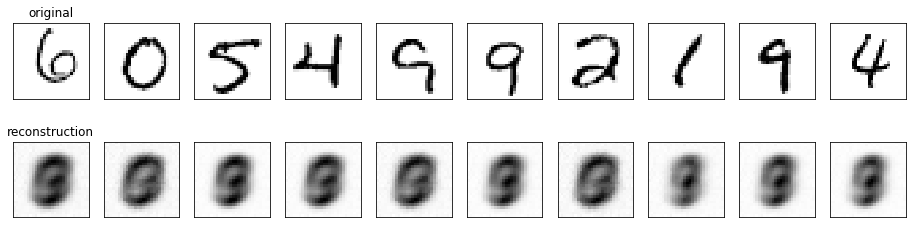

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

n_samples = original_image.shape[0]

_, axarr = plt.subplots(2, n_samples, figsize=(16,4))

for i, x in enumerate(original):
    axarr[0,i].imshow(x.reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[0,i].set_title('original')
    #axarr[0,i].axis('off')
    axarr[0,i].get_xaxis().set_ticks([])
    axarr[0,i].get_yaxis().set_ticks([])
    axarr[1,i].imshow(result[i].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[1,i].set_title('reconstruction')
    #axarr[1,i].axis('off')
    axarr[1,i].get_xaxis().set_ticks([])
    axarr[1,i].get_yaxis().set_ticks([])
plt.show()

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

test_input = nd.random_normal(loc = 0,scale = 2,shape= LATENT_DIM, ctx = gpu_ctx)
t_i = test_input.reshape((-1, LATENT_DIM))
test_gen = dec(t_i)
t_g = nd.transpose(test_gen, (0, 2, 3, 1))
im = nd.transpose(t_g,(1,0,2,3))
im = nd.reshape(im,(28, 28,1))
imtiles = nd.tile(im, (1,1,3))
plt.imshow(imtiles.asnumpy())
plt.show()

after dense1....(1, 128)
after dense2.... (1, 784)


MXNetError: [20:30:46] src/operator/tensor/./matrix_op-inl.h:310: Check failed: shp.ndim() == param.axes.ndim() (2 vs. 4) 

Stack trace returned 10 entries:
[bt] (0) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x28965c) [0x7f7d75daa65c]
[bt] (1) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x226b868) [0x7f7d77d8c868]
[bt] (2) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x24d573f) [0x7f7d77ff673f]
[bt] (3) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x24c1be9) [0x7f7d77fe2be9]
[bt] (4) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x24026bb) [0x7f7d77f236bb]
[bt] (5) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/mxnet/libmxnet.so(MXImperativeInvokeEx+0x63) [0x7f7d77f23bf3]
[bt] (6) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7f7daf864ec0]
[bt] (7) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7f7daf86487d]
[bt] (8) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7f7dafa7982e]
[bt] (9) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(+0x12265) [0x7f7dafa7a265]


In [28]:
test_gen


[[[[ 0.50028056  0.50006336  0.50001007  0.50009346  0.49996209  0.50000113
     0.49992168  0.49999869  0.50012594  0.50015461  0.49982446  0.49991751
     0.50012875  0.49998283  0.500054    0.50003207  0.49995345  0.50020087
     0.50006247  0.50009751  0.50001132  0.50002122  0.50020128  0.50011408
     0.50015682  0.50007886  0.50016648  0.49989346]
   [ 0.50011837  0.50011653  0.50027168  0.50032485  0.50028926  0.50001252
     0.50006485  0.49996322  0.50024915  0.50002694  0.50019926  0.50000727
     0.50022888  0.50010306  0.50001353  0.50021893  0.5002014   0.4999401
     0.50021875  0.49995762  0.50036168  0.50027966  0.49988237  0.50007564
     0.50023842  0.50001597  0.50022185  0.50012606]
   [ 0.50005227  0.49979421  0.50009608  0.49971488  0.50017655  0.50009847
     0.5001843   0.49974751  0.50009674  0.49989203  0.50011927  0.49963233
     0.50005466  0.50025785  0.49996638  0.49961466  0.49995768  0.49970406
     0.50039279  0.49965215  0.50003338  0.50002873  0.500

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def model_predict(net,data):
    output = dec(data.as_in_context(model_ctx))
    return nd.argmax(output, axis=1)

NUM_EXAMPLES = 10
# let's sample 10 random data points from the test set
sample_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                              NUM_EXAMPLES, shuffle=True)

for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(gpu_ctx)
    data_t = nd.transpose(data, (0, 2, 3, 1))
    im1 = nd.transpose(data,(1, 0, 2, 3))
    im1 = nd.reshape(im1,(28, NUM_EXAMPLES * 28,1))
    imtiles1 = nd.tile(im1, (1,1,3))
    
    gen, _, _ = vae(data)
    gen_t = nd.transpose(gen, (0, 2, 3, 1))
    im2 = nd.transpose(gen_t,(1, 0, 2, 3))
    im2 = nd.reshape(im2,(28, NUM_EXAMPLES * 28, 1))
    imtiles2 = nd.tile(im2, (1,1,3))
    
    f, (plt1, plt2) = plt.subplots(2, 1)
    plt1.imshow(imtiles1.asnumpy())
    plt2.imshow(imtiles2.asnumpy())
    f.show()
    #pred=model_predict(net,data.reshape((-1,784)))
    #print('model predictions are:', pred)
    break